**patient data**

In [1]:
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [2]:
X = torch.tensor([[72, 120, 37.3, 104, 32.5],
                 [85, 130, 37.0, 110, 14],
                 [68, 110, 38.5, 125, 34],
                 [90, 140, 38.0, 130, 26],
                 [84, 132, 38.3, 146, 30],
                 [78, 128, 37.2, 102, 12]], dtype = torch.float64)

W = torch.tensor([[-0.1, 0.5, 0.3],
                  [0.9, 0.3, 0.5],
                  [-1.5, 0.4, 0.1],
                  [0.1, 0.1, -1.0],
                  [-1.2, 0.5, -0.8]], dtype = torch.float64,requires_grad=True)


optimizer = torch.optim.Adam([W],lr=1e-02)

lable = np.array(['non-diabetic',
              'diabetic',
              'non-diabetic',
              'pre-diabetic',
              'diabetic',
              'pre-diabetic'])


sc = StandardScaler()
std_patient = torch.tensor(sc.fit_transform(X),dtype=torch.float64)

ohe = OneHotEncoder(sparse_output=False)
lableOHE = lable.reshape(-1,1)
lableOHE = torch.tensor(ohe.fit_transform(lableOHE),dtype=torch.float64)


def lossfun(W):
  raw_score = torch.matmul(std_patient,W)
  softmax = torch.nn.Softmax()
  loss = softmax(raw_score)
  loss = torch.sum(lableOHE*loss,dim=1)
  return torch.mean(-torch.log(loss))


for i in range(10000):
  optimizer.zero_grad()
  loss = lossfun(W)
  loss = loss.backward()
  optimizer.step()
print(W)


c:\Users\Dell\miniconda3\envs\ALA\Lib\site-packages\torch\nn\modules\module.py:1773: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([[  6.7107,  -2.7438,   1.0328],
        [ -9.0516,  -3.2974,   6.8151],
        [ -5.3327,  -2.6336,  13.2100],
        [  5.1068,  -3.9332, -15.8885],
        [ -1.4233,   6.5601,  -1.1260]], dtype=torch.float64,
       requires_grad=True)


**Stock**

In [3]:
import yfinance as yf
import seaborn as sns

In [4]:
stocks = ['AAPL', 'MSFT', 'GOOG', 'TSLA', 'JNJ', 'JPM', 'NVDA', 'AMZN', 'META', 'XOM']
DF_stock = yf.download(stocks,start="2024-08-01",end="2025-08-01")
DF_stock = DF_stock['Close']


C:\Users\Dell\AppData\Local\Temp\ipykernel_10120\2896741622.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  DF_stock = yf.download(stocks,start="2024-08-01",end="2025-08-01")
[*********************100%***********************]  10 of 10 completed


In [5]:
log_returns = np.log(DF_stock/DF_stock.shift(1)).dropna()
print(log_returns.cov())
print(log_returns.corr())

Ticker      AAPL      AMZN      GOOG       JNJ       JPM      META      MSFT  \
Ticker                                                                         
AAPL    0.000393  0.000247  0.000193  0.000021  0.000164  0.000250  0.000175   
AMZN    0.000247  0.000462  0.000272 -0.000039  0.000211  0.000364  0.000242   
GOOG    0.000193  0.000272  0.000386 -0.000032  0.000140  0.000242  0.000167   
JNJ     0.000021 -0.000039 -0.000032  0.000149  0.000019 -0.000047 -0.000027   
JPM     0.000164  0.000211  0.000140  0.000019  0.000308  0.000188  0.000123   
META    0.000250  0.000364  0.000242 -0.000047  0.000188  0.000526  0.000244   
MSFT    0.000175  0.000242  0.000167 -0.000027  0.000123  0.000244  0.000247   
NVDA    0.000299  0.000426  0.000340 -0.000108  0.000249  0.000439  0.000335   
TSLA    0.000428  0.000514  0.000464 -0.000030  0.000364  0.000498  0.000328   
XOM     0.000122  0.000077  0.000058  0.000039  0.000106  0.000080  0.000035   

Ticker      NVDA      TSLA       XOM  


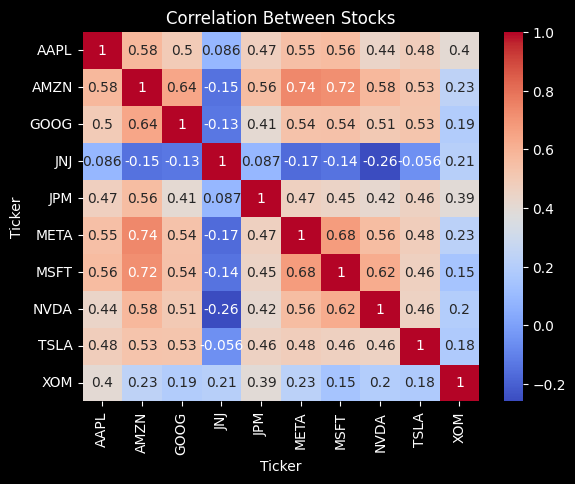

In [6]:
corrmatrix = log_returns.corr()
sns.heatmap(corrmatrix,cmap='coolwarm',annot=True);
plt.title("Correlation Between Stocks")
plt.show()

In [7]:
r = torch.tensor(log_returns.mean().values,dtype=torch.float64)
w = torch.tensor(0.1*np.ones(10),dtype=torch.float64,requires_grad=True)
cov = np.array(log_returns.cov())
s = torch.tensor(cov)

optimizer = torch.optim.Adam([w],lr=1e-02)

def lossfun(w):
  loss = -(torch.dot(w,r)/torch.dot(w,torch.matmul(w,s)))
  return loss

for i in range(10000):
  optimizer.zero_grad()
  w_constraint = torch.softmax(w,dim=0)
  loss = lossfun(w_constraint)
  loss.backward()
  optimizer.step()

w = torch.softmax(w,dim=0)


In [8]:
print(w)

tensor([2.1166e-06, 2.1945e-06, 3.8791e-06, 4.5253e-01, 2.0601e-01, 1.1891e-01,
        1.9956e-01, 2.2981e-02, 3.1562e-06, 1.9334e-06], dtype=torch.float64,
       grad_fn=<SoftmaxBackward0>)


In [9]:
avg_returns = torch.dot(w,r)
ovrall_risk = torch.dot(w,torch.matmul(s,w))
sharp = avg_returns/ovrall_risk
print('sharp ratio ',sharp)

sharp ratio  tensor(9.5677, dtype=torch.float64, grad_fn=<DivBackward0>)


In [10]:
ovrall_risk

tensor(9.1386e-05, dtype=torch.float64, grad_fn=<DotBackward0>)

**FOOD**

In [11]:
#test patient

# p = torch.tensor([
#     [76,126,38],
#     [74,120,38],
#     [72,118,37.5],
#     [78,136,37],
# ],dtype=torch.float64)


In [16]:
p = pd.read_csv('data/food-texture.csv',header=0)
p = sc.fit_transform(p.iloc[:,1:])
p = torch.tensor(np.array(p),dtype=torch.float64)

In [17]:
pm = torch.mean(p,dim=0)

w = torch.tensor(np.ones(p.shape[1]),dtype=torch.float64,requires_grad=True)

optimizer = torch.optim.Adam([w],lr=1e-02)
# optimizer = torch.optim.SGD([w],lr=1e-02)

def unit(v):
  return v/torch.norm(v)

def lossfun(w):
  w = unit(w)
  loss = -torch.mean(torch.square(torch.matmul(p,w)-torch.dot(pm,w)))
  return loss

for i in range(1000):
  optimizer.zero_grad()
  loss = lossfun(w)
  if i%100==0:
    print(f'{i}',loss)
  loss.backward()
  optimizer.step()

print(w)

#using SGD tensor([ 1.0222, -1.0694,  1.1958, -1.1331,  0.3526], dtype=torch.float64,
#using Adam tensor([ 0.9488, -0.9928,  1.1040, -1.0462,  0.3181], dtype=torch.float64,

0 tensor(-0.3665, dtype=torch.float64, grad_fn=<NegBackward0>)
100 tensor(-1.9255, dtype=torch.float64, grad_fn=<NegBackward0>)
200 tensor(-3.0227, dtype=torch.float64, grad_fn=<NegBackward0>)
300 tensor(-3.0312, dtype=torch.float64, grad_fn=<NegBackward0>)
400 tensor(-3.0312, dtype=torch.float64, grad_fn=<NegBackward0>)
500 tensor(-3.0312, dtype=torch.float64, grad_fn=<NegBackward0>)
600 tensor(-3.0312, dtype=torch.float64, grad_fn=<NegBackward0>)
700 tensor(-3.0312, dtype=torch.float64, grad_fn=<NegBackward0>)
800 tensor(-3.0312, dtype=torch.float64, grad_fn=<NegBackward0>)
900 tensor(-3.0312, dtype=torch.float64, grad_fn=<NegBackward0>)
tensor([ 0.9488, -0.9928,  1.1040, -1.0462,  0.3181], dtype=torch.float64,
       requires_grad=True)
